<h1><center>Twitiment</center></h1>

<center>Analyzing the sentiment of tweets using VADER and RoBERTa NLP models, as well a DistilBERT HuggingTree Pipeline.<center>

<h3>Import Dependancies + Setup Environment</h3>

In [2]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

packages = ['punkt', 'averaged_perceptron_tagger',
            'maxent_ne_chunker', 'words', 'vader_lexicon']

for package in packages:
    nltk.download(package)

dataset = load_dataset("tweet_eval", "sentiment")

plt.style.use('ggplot')


[nltk_data] Downloading package punkt to /Users/aum/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aum/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/aum/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/aum/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/aum/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Found cached dataset tweet_eval (/Users/aum/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

We're primarily going to be working with the training dataset -- let's convert it to a `pandas.DataFrame` object, add an id value to each row, and call `head()` to see the first few rows of data. 

In [3]:
train_data = dataset['train']

df_train = pd.DataFrame(train_data)
df_train = df_train.reset_index().rename(columns={'index': 'id'})

df_train.head()

,id,text,label
0,0,"""QT @user In the original draft of the 7th boo...",2
1,1,"""Ben Smith / Smith (concussion) remains out of...",1
2,2,Sorry bout the stream last night I crashed out...,1
3,3,Chase Headley's RBI double in the 8th inning o...,1
4,4,@user Alciato: Bee will invest 150 million in ...,2


`value_counts()` tells us how many tweets are assigned to the labels 0, 1, and 2.

In [4]:
df_train['label'].value_counts()

1    20673
2    17849
0     7093
Name: label, dtype: int64

Before we work with the VADER model, let's construct a demo of how tweets are processed by NLTK, the Natural Language Tool Kit. Here, we tokenize the tweet, label each token with its part of speech, identify any named entities, and then pretty-print out the resulting structure.

In [38]:
example = df_train['text'] [50]
example_label = df_train['label'][50]
tokenized_example = nltk.word_tokenize(example)
tagged_example = nltk.pos_tag(tokenized_example)
entities = nltk.chunk.ne_chunk(tagged_example)
entities.pprint()

(S
  (GPE Thanks/NNS)
  manager/NN
  for/IN
  putting/VBG
  me/PRP
  on/IN
  the/DT
  schedule/NN
  for/IN
  Sunday/NNP
  ''/'')


<h2><center>VADER</center><h2>



Short for Valence Aware Dictionary and sEntiment Reasoner, a VADER model approaches sentiment analysis through a sentiment lexicon -- a list of lexical features that are assigned labels of positive or negative based on their semantic orientation. Vader sentiment lexicon takes into account popular slang, emoticons, and acronyms, and the intensity of sentiment.

In [155]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

Here, we calculate the VADER scores and assign them to the `results` dictionary.

In [7]:
results = {}
for i, row in tqdm(df_train.iterrows(), total=len(df_train)):
    text = row['text']
    results[i] = sia.polarity_scores(text)

  0%|          | 0/45615 [00:00<?, ?it/s]

Lets create a `pandas.DataFrame` out of the `results` dictionary and `merge()` it with our training dataset.

In [8]:
vader = pd.DataFrame(results).T
vader = vader.reset_index().rename(columns={'index': 'id'})
vader = vader.merge(df_train, how='left')
vader.head()

,id,neg,neu,pos,compound,text,label
0,0,0.101,0.544,0.355,0.7603,"""QT @user In the original draft of the 7th boo...",2
1,1,0.000,1.000,0.000,0.0000,"""Ben Smith / Smith (concussion) remains out of...",1
2,2,0.046,0.837,0.118,0.4215,Sorry bout the stream last night I crashed out...,1
3,3,0.000,1.000,0.000,0.0000,Chase Headley's RBI double in the 8th inning o...,1
4,4,0.000,1.000,0.000,0.0000,@user Alciato: Bee will invest 150 million in ...,2


<h3><center>VADER Results</center><h3>

If we compare our VADER compound scores with the given sentiment values, we can see that the model did a pretty good job.

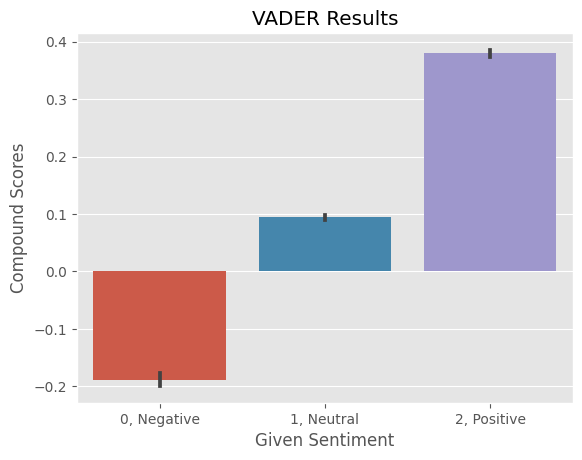

In [9]:
graph = sns.barplot(data=vader, x='label', y='compound')
graph.set_ylabel('Compound Scores')
graph.set_xlabel('Given Sentiment')
graph.set_xticklabels(['0, Negative', '1, Neutral', '2, Positive'])
graph.set_title('VADER Results')
plt.show()

And if we look at the individual neg, neu, and pos VADER sentiment scores, it follows the expected trend.

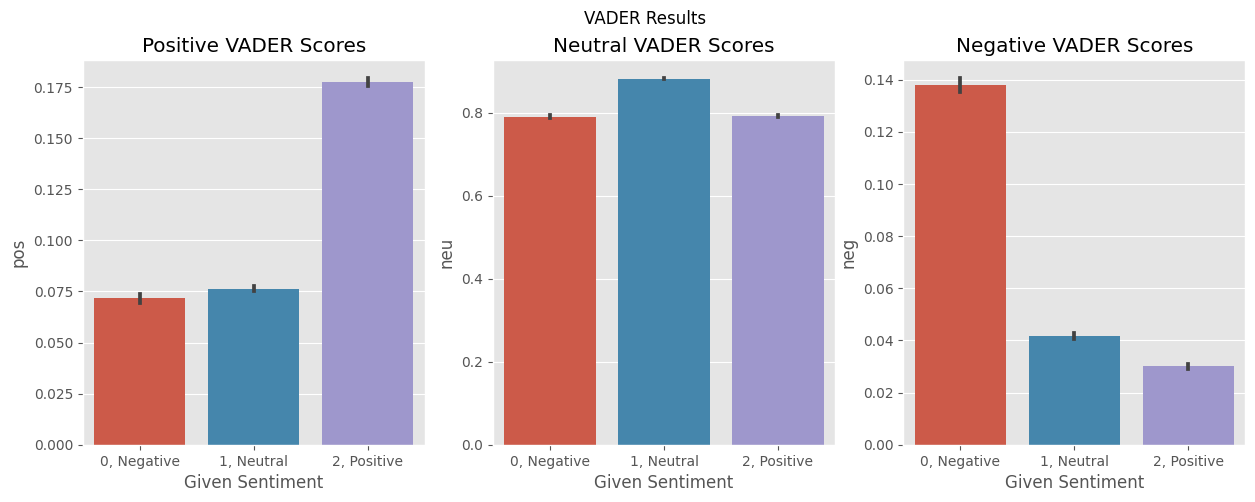

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('VADER Results')

sns.barplot(data=vader, x='label', y='pos', ax=axs[0]).set_xticklabels(
    ['0, Negative', '1, Neutral', '2, Positive'])
axs[0].set_xlabel('Given Sentiment')
axs[0].set_title('Positive VADER Scores')

sns.barplot(data=vader, x='label', y='neu', ax=axs[1]).set_xticklabels(
    ['0, Negative', '1, Neutral', '2, Positive'])
axs[1].set_xlabel('Given Sentiment')
axs[1].set_title('Neutral VADER Scores')

sns.barplot(data=vader, x='label', y='neg', ax=axs[2]).set_xticklabels(
    ['0, Negative', '1, Neutral', '2, Positive'])
axs[2].set_xlabel('Given Sentiment')
axs[2].set_title('Negative VADER Scores')

plt.show()


<h2><center>RoBERTa</center><h2>

RoBERTa (Robustly Optimized BERT Pretraining Approach) is NLP model built upon BERT (Bidirectional Encoder Representations from Transformers). BERT introduced a new, bidirectional approach to understanding the context of each word in a sentence. Before BERT, NLP models would read text either from left-to-right or right-to-left. But language often requires understanding the context from both sides. Here's where BERT makes a difference—it reads text in both directions at once, hence the "bidirectional" in its name. This allows BERT to understand the context of a word based on all of its surroundings (to the left and the right of the word).


RoBERTa aims to address some of BERT's shortcomings by using larger training datasets, removing NSP (next sentence prediction) to improve performance, changing learning rate schedules, and using dynamic masking instead of BERT's static masking. Masking refers to the technique of 'hiding' words in a sentences and asking the model to predict the hidden words. But dynamically changing the masking forces the NLP model to pay attention to the whole sentences, instead of 'memorizing' the right answer, which can occur with static masking.

In [11]:
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from scipy.special import softmax

In [28]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Remember our example tweet and its VADER scores:

In [29]:
# VADER example
print(example)
sia.polarity_scores(example)

Thanks manager for putting me on the schedule for Sunday"


{'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'compound': 0.4404}

Now lets run the RoBERTa model on this example tweet.

In [48]:
# RoBERTa model

def getRobertaScores(tweet):
    encoded_text = tokenizer(tweet, return_tensors='tf')
    output = model(**encoded_text)
    scores = output[0][0].numpy() # for pytorch, do .detach().numpy
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

print(getRobertaScores(example))


{'roberta_neg': 0.0039595934, 'roberta_neu': 0.15979941, 'roberta_pos': 0.836241}


If we compare our VADER and RoBERTa results, we can see that the RoBERTa model finds the tweet to have a more positive sentiment -- which I would probably disagree with. The 'bag of words' approach that the VADER model takes and the RoBERTa model don't seem to be able to capture the irony of this tweet (or so I think).

Let's run the RoBERTa model on all our training tweets.

In [35]:
results = {}
# Slicing the dataframe to the first 500 rows, you can adjust this
for i, row in tqdm(df_train.iloc[:500].iterrows(), total=500):
    try:
        text = row['text']
        vaderScores = sia.polarity_scores(text)
        vaderResult = {}
        for key, value in vaderScores.items():
            vaderResult[f"vader_{key}"] = value
        robertaScores = getRobertaScores(text)
        combined = {**vaderResult, **robertaScores}
        results[i] = combined
    except RuntimeError:
        print(f'Did not work for {i}')



  0%|          | 0/500 [00:00<?, ?it/s]

In [49]:
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df_train, how='left')
results_df.head()


,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,text,label
0,0,0.101,0.544,0.355,0.7603,0.001923,0.103815,0.894262,"""QT @user In the original draft of the 7th boo...",2
1,1,0.000,1.000,0.000,0.0000,0.155160,0.822582,0.022259,"""Ben Smith / Smith (concussion) remains out of...",1
2,2,0.046,0.837,0.118,0.4215,0.285676,0.522337,0.191987,Sorry bout the stream last night I crashed out...,1
3,3,0.000,1.000,0.000,0.0000,0.004170,0.781665,0.214165,Chase Headley's RBI double in the 8th inning o...,1
4,4,0.000,1.000,0.000,0.0000,0.006908,0.793153,0.199939,@user Alciato: Bee will invest 150 million in ...,2


<h3><center>RoBERTa Results</center><h3>

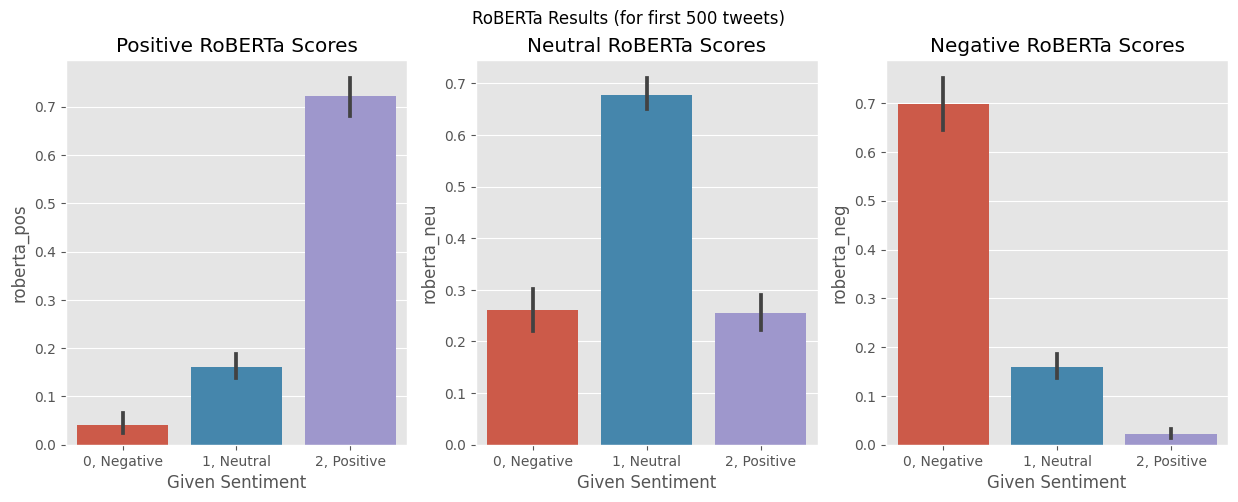

In [156]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('RoBERTa Results (for first 500 tweets)')

sns.barplot(data=results_df, x='label', y='roberta_pos', ax=axs[0]).set_xticklabels(
    ['0, Negative', '1, Neutral', '2, Positive'])
axs[0].set_xlabel('Given Sentiment')
axs[0].set_title('Positive RoBERTa Scores')

sns.barplot(data=results_df, x='label', y='roberta_neu', ax=axs[1]).set_xticklabels(
    ['0, Negative', '1, Neutral', '2, Positive'])
axs[1].set_xlabel('Given Sentiment')
axs[1].set_title('Neutral RoBERTa Scores')

sns.barplot(data=results_df, x='label', y='roberta_neg', ax=axs[2]).set_xticklabels(
    ['0, Negative', '1, Neutral', '2, Positive'])
axs[2].set_xlabel('Given Sentiment')
axs[2].set_title('Negative RoBERTa Scores')

plt.show()

Although RoBERTa thought our example tweet about having to work on a Sunday was a positive statement, we can see that the model seems to do a better job at determining the sentiment of tweets.

<h2><center>Comparing VADER and RoBERTa</center></h2>

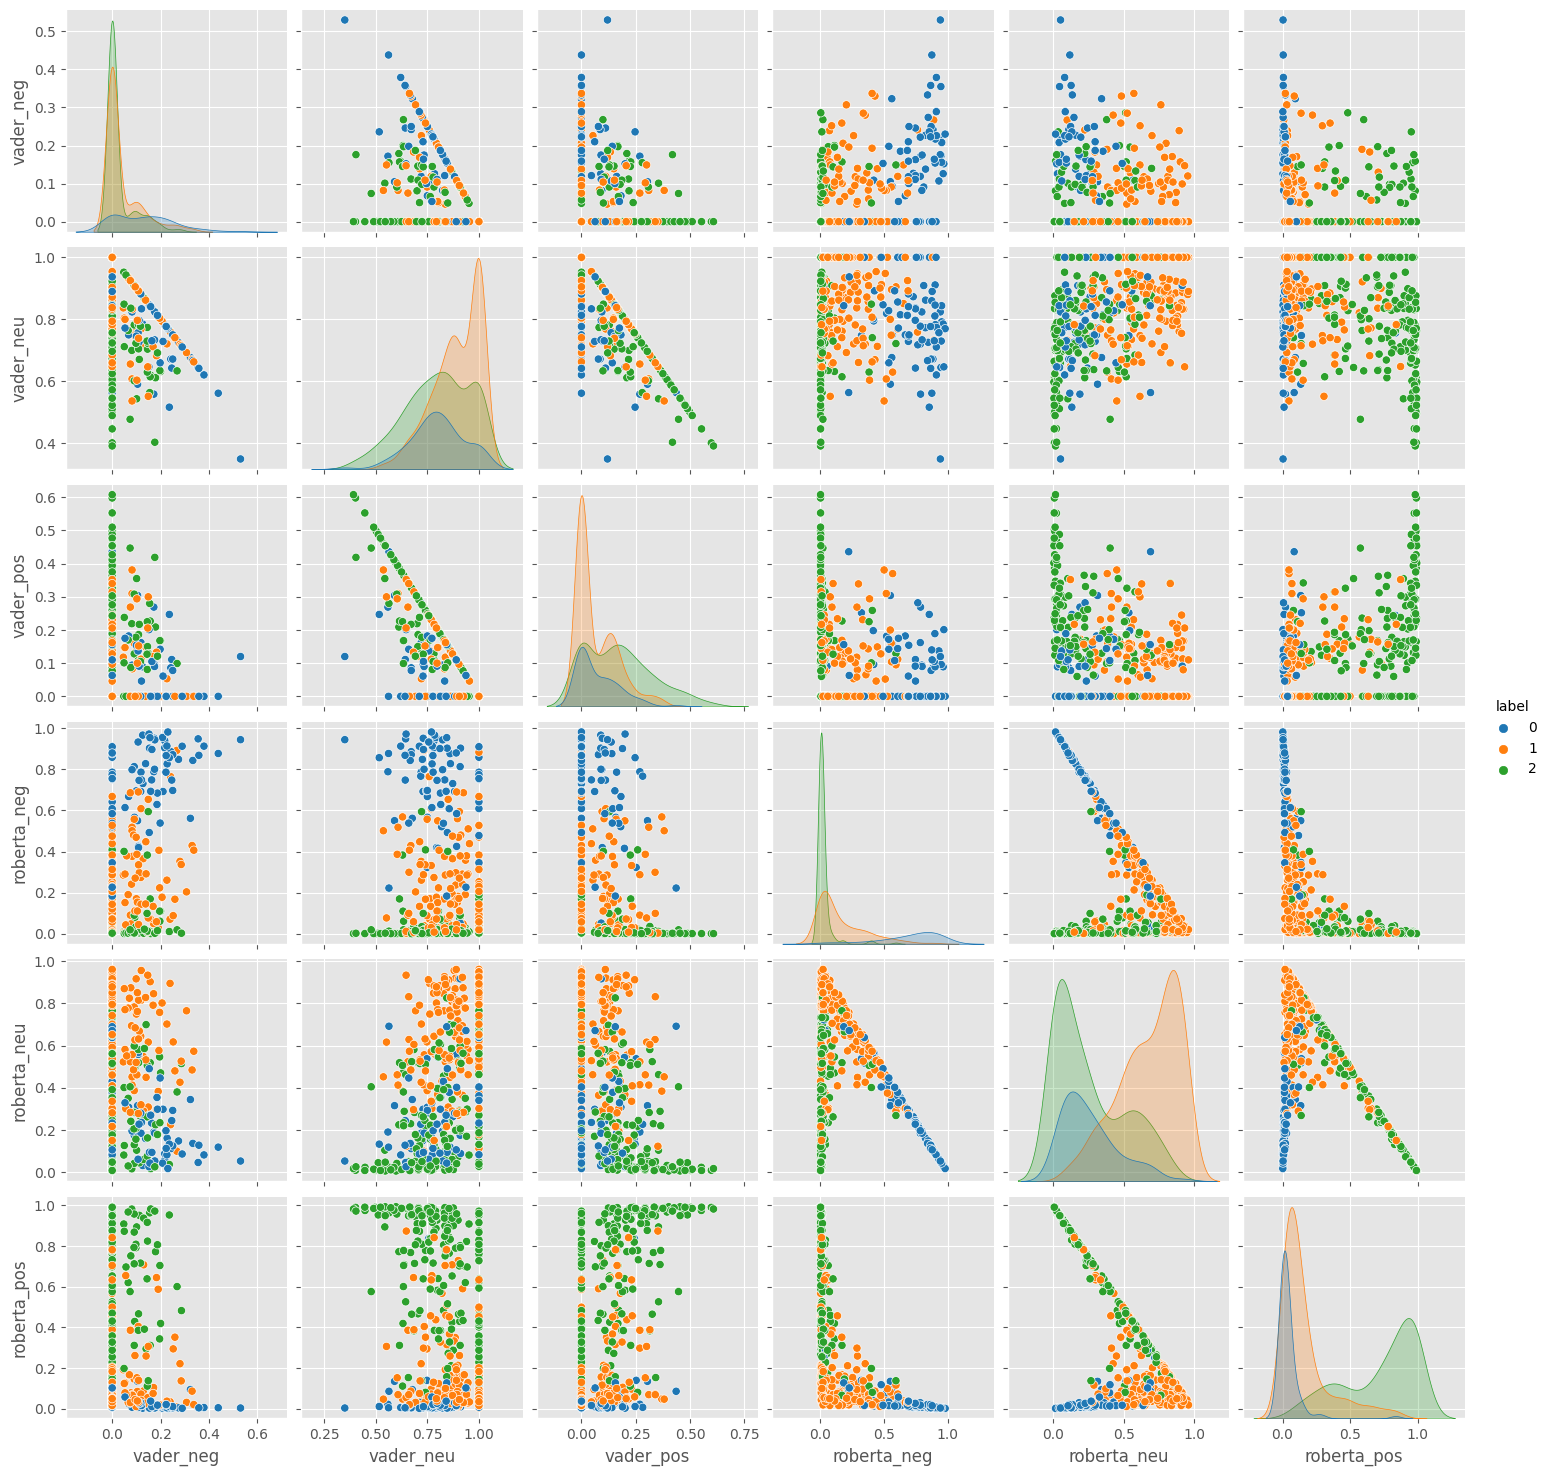

In [54]:
sns.pairplot(data=results_df, vars=[
             'vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='label',
             palette='tab10'
             )
plt.show()



From these graphs, we can see that the RoBERTa model is much more 'confident' in it's predictions -- it seems to strongly seperate out the sentiment of tweets.

<h3><center>Some Examples</center></h3>

To see how the models differ, we can look at some example tweets. Let's query the dataframe for tweets labeled negative, which VADER and RoBERTa seem to think are more positive.

In [60]:
print(results_df.query('label == 0').sort_values('vader_pos', ascending=False)['text'].values[0])
print(results_df.query('label == 0').sort_values('roberta_pos', ascending=False)['text'].values[0])


Yes it is. Bori practitioners have survived by not attempting to abandon Islam. So they blend in easily.
Thanks manager for putting me on the schedule for Sunday"


I can understand why the VADER model thinks it's a positive tweet (I don't understand why it isn't). And for the RoBERTa model, it's the same tweet from before! Now lets look at tweets labeled positive which our Models think are negative.

In [68]:
print(results_df.query('label == 2').sort_values('vader_neg', ascending=False)['text'].values[0])
print(results_df.query('label == 2').sort_values('roberta_neg', ascending=False)['text'].values[0])

Josh's T-shirt for Star Wars day in school on Friday.
Plant City is babysitting NYC palm trees for the winter. Crap like this cracks me up!


Well, I don't understand the first tweet, nor do I know what the second tweet is talking about -- but interesting nonetheless.

<h2><center>HuggingFace Transformer Pipeline</center></h2>

HuggingFace's transformer pipeline make NLP and other ML models extremely simple to use. Here, we can use the sentiment analysis pipeline -- let's not specify model as the cardiffNLP Twitter RoBERTa model we used earlier, by default it should use the DistilBERT model, a 'distilled' version of the BERT model.

In [69]:
from transformers import pipeline

sentimentAnalysis = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


Although the format is a bit different, we can still see that we have sentiment analysis functionality!

In [104]:
print(example)
sentimentAnalysis(example)[0]

Thanks manager for putting me on the schedule for Sunday"


{'label': 'NEGATIVE', 'score': 0.9985024929046631}

Now lets use the pipeline to analyze tweets and compare it to other models. Keep in mind that this model is not trained to analyze the sentiment of tweets, which often contains more emoticons, slang, and acronyms than DistilBERT may be trained with.

In [93]:
results = {}
# Slicing the dataframe to the first 500 rows, you can adjust this
for i, row in tqdm(df_train.iloc[:500].iterrows(), total=500):
    try:
        text = row['text']
        vaderScores = sia.polarity_scores(text)
        vaderResult = {}
        for key, value in vaderScores.items():
            vaderResult[f"vader_{key}"] = value
        robertaScores = getRobertaScores(text)
        pipelineResult = {}
        pipelineResult['pipelineLabel'] = sentimentAnalysis(text)[0]['label']
        pipelineResult['pipelineScore'] = sentimentAnalysis(text)[0]['score']
        combined = {**vaderResult, **robertaScores, **pipelineResult}
        results[i] = combined
    except RuntimeError:
        print(f'Did not work for {i}')


  0%|          | 0/500 [00:00<?, ?it/s]

In [131]:
pipeline_df = pd.DataFrame(results).T
pipeline_df = pipeline_df.reset_index().rename(columns={'index': 'id'})
pipeline_df = pipeline_df.merge(df_train, how='left')
pipeline_df.head()


,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,pipelineLabel,pipelineScore,text,label
0,0,0.101,0.544,0.355,0.7603,0.001923,0.103815,0.894262,NEGATIVE,0.971383,"""QT @user In the original draft of the 7th boo...",2
1,1,0.0,1.0,0.0,0.0,0.15516,0.822582,0.022259,NEGATIVE,0.996968,"""Ben Smith / Smith (concussion) remains out of...",1
2,2,0.046,0.837,0.118,0.4215,0.285676,0.522337,0.191987,POSITIVE,0.931442,Sorry bout the stream last night I crashed out...,1
3,3,0.0,1.0,0.0,0.0,0.00417,0.781665,0.214165,POSITIVE,0.989131,Chase Headley's RBI double in the 8th inning o...,1
4,4,0.0,1.0,0.0,0.0,0.006908,0.793153,0.199939,NEGATIVE,0.746178,@user Alciato: Bee will invest 150 million in ...,2


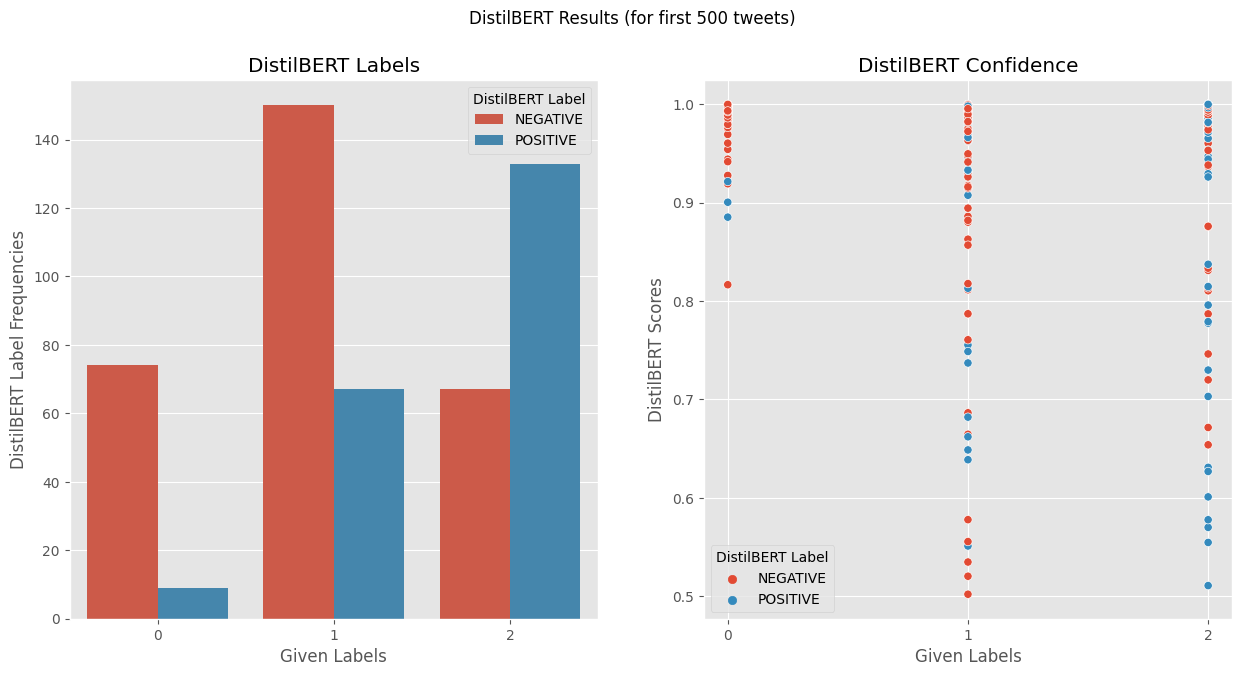

In [157]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

plt.suptitle('DistilBERT Results (for first 500 tweets)')

grouped_df = pipeline_df.groupby(
    ['label', 'pipelineLabel']).size().reset_index(name='counts')
sns.barplot(data=grouped_df, x='label', y='counts',
            hue='pipelineLabel', ax=ax1)

ax1.set_title('DistilBERT Labels')
ax1.set_xlabel('Given Labels')
ax1.set_ylabel('DistilBERT Label Frequencies')
ax1.legend().set_title('DistilBERT Label')

sns.scatterplot(data=pipeline_df, x='label',
                y='pipelineScore', hue='pipelineLabel', ax=ax2)

x_ticks = np.arange(pipeline_df['label'].min(),
                    pipeline_df['label'].max() + 1, step=1)
ax2.set_xticks(x_ticks)

ax2.set_title('DistilBERT Confidence')
ax2.set_xlabel('Given Labels')
ax2.set_ylabel('DistilBERT Scores')
ax2.legend().set_title('DistilBERT Label')

plt.show()

The weaknesses of the lack of specified training for the DistilBERT model shows in these graphs. The transformer pipeline we used, although faintly accurate, doesn't consider neutral sentiment and is not very confident when assessing tweets with a neutral or positive sentiment.